In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

In [4]:
# prepare data
crsp = pd.read_csv('CRSP.csv')
crsp['RET'] = pd.to_numeric(crsp['RET'],errors = 'coerce')
crsp['date'] = pd.to_datetime(crsp['date'], format = '%Y%m%d')+ pd.offsets.MonthEnd(0)
ff = pd.read_csv('ff.csv', index_col = 'Date', parse_dates = True)
ff['Mkt-RF'] = pd.to_numeric(ff['Mkt-RF'], errors = 'coerce')
ff['RF'] = pd.to_numeric(ff['RF'], errors = 'coerce')
ff['Mkt'] = ff['Mkt-RF'] + ff['RF']
ff.index = pd.to_datetime(ff.index, format='%Y%m') + pd.offsets.MonthEnd(0)
ff.reset_index(inplace = True)
ff.rename(columns={'Mkt-RF' : 'Mkt_RF','Date': 'date'}, inplace=True)
ff

,date,Mkt_RF,SMB,HML,RF,Mkt
0,1926-07-31,2.96,-2.30,-2.87,0.22,3.18
1,1926-08-31,2.64,-1.40,4.19,0.25,2.89
2,1926-09-30,0.36,-1.32,0.01,0.23,0.59
3,1926-10-31,-3.24,0.04,0.51,0.32,-2.92
4,1926-11-30,2.53,-0.20,-0.35,0.31,2.84
...,...,...,...,...,...,...
1117,2019-08-31,-2.58,-2.41,-4.99,0.16,-2.42
1118,2019-09-30,1.44,-0.90,6.71,0.18,1.62
1119,2019-10-31,2.06,0.25,-2.07,0.15,2.21
1120,2019-11-30,3.87,0.87,-1.86,0.12,3.99


In [5]:
crsp

,PERMNO,date,SHRCD,PERMCO,PRC,RET,SHROUT
0,10000,1986-01-31,10,7952,-4.37500,NaN,3680.0
1,10000,1986-02-28,10,7952,-3.25000,-0.257143,3680.0
2,10000,1986-03-31,10,7952,-4.43750,0.365385,3680.0
3,10000,1986-04-30,10,7952,-4.00000,-0.098592,3793.0
4,10000,1986-05-31,10,7952,-3.10938,-0.222656,3793.0
...,...,...,...,...,...,...,...
3645517,93436,2019-08-31,11,53453,225.61000,-0.066222,179127.0
3645518,93436,2019-09-30,11,53453,240.87000,0.067639,180000.0
3645519,93436,2019-10-31,11,53453,314.92001,0.307427,180245.0
3645520,93436,2019-11-30,11,53453,329.94000,0.047695,180245.0


In [9]:
#Calculate past 12 months Rolling Return 
crsp.sort_values(['PERMNO', 'date'], inplace = True)
crsp.loc[crsp.groupby('PERMNO').head(1).index, 'RET'] = np.nan
crsp['log1pRET'] = np.log(crsp['RET'] + 1)
crsp['sumlog1pRET'] = crsp['log1pRET'].rolling(window=12).sum()
crsp['RET12'] = np.exp(crsp['sumlog1pRET']) - 1
crsp.dropna(subset = ['RET12'], inplace=True)
crsp

,PERMNO,date,SHRCD,PERMCO,PRC,RET,SHROUT,log1pRET,sumlog1pRET,RET12
42,10001,1988-01-31,11,7953,6.25000,0.063830,992.0,0.061876,-0.008535,-0.008499
43,10001,1988-02-29,11,7953,6.75000,0.080000,992.0,0.076961,0.145387,0.156487
44,10001,1988-03-31,11,7953,6.12500,-0.076296,992.0,-0.079364,0.029884,0.030335
45,10001,1988-04-30,11,7953,-6.31250,0.030612,992.0,0.030153,0.100042,0.105218
46,10001,1988-05-31,11,7953,-6.43750,0.019802,992.0,0.019608,0.193759,0.213804
...,...,...,...,...,...,...,...,...,...,...
3645517,93436,2019-08-31,11,53453,225.61000,-0.066222,179127.0,-0.068517,-0.290492,-0.252104
3645518,93436,2019-09-30,11,53453,240.87000,0.067639,180000.0,0.065450,-0.094603,-0.090266
3645519,93436,2019-10-31,11,53453,314.92001,0.307427,180245.0,0.268061,-0.068712,-0.066405
3645520,93436,2019-11-30,11,53453,329.94000,0.047695,180245.0,0.046593,-0.060391,-0.058603


In [17]:
# Form portfolios
# For every month, form a portfolio consisting of different stocks and devide those stocks into 10 groups
# shift two monthes backward to make sure we use previous returns to predict the following reutrns
portfolios = crsp[['date', 'PERMNO', 'RET12']].copy()
portfolios['Q10_RET12'] = portfolios.groupby('date')['RET12'].transform(lambda x : pd.qcut(x, 10, labels = False))
portfolios['date'] = portfolios['date'] + pd.offsets.MonthEnd(2)
portfolios

,date,PERMNO,RET12,Q10_RET12
42,1988-03-31,10001,-0.008499,7.0
43,1988-04-30,10001,0.156487,8.0
44,1988-05-31,10001,0.030335,7.0
45,1988-06-30,10001,0.105218,7.0
46,1988-07-31,10001,0.213804,8.0
...,...,...,...,...
3645517,2019-10-31,93436,-0.252104,3.0
3645518,2019-11-30,93436,-0.090266,5.0
3645519,2019-12-31,93436,-0.066405,4.0
3645520,2020-01-31,93436,-0.058603,3.0


In [33]:
merged = pd.merge(crsp, portfolios[['Q10_RET12', 'PERMNO', 'date']], on = ['PERMNO', 'date'])
merged.set_index('date', inplace = True)
merged

,PERMNO,SHRCD,PERMCO,PRC,RET,SHROUT,log1pRET,sumlog1pRET,RET12,Q10_RET12
date,,,,,,,,,,
1988-03-31,10001,11,7953,6.12500,-0.076296,992.0,-0.079364,0.029884,0.030335,7.0
1988-04-30,10001,11,7953,-6.31250,0.030612,992.0,0.030153,0.100042,0.105218,8.0
1988-05-31,10001,11,7953,-6.43750,0.019802,992.0,0.019608,0.193759,0.213804,7.0
1988-06-30,10001,11,7953,6.25000,-0.012039,992.0,-0.012112,0.131497,0.140535,7.0
1988-07-31,10001,11,7953,-6.43750,0.030000,992.0,0.029559,0.140002,0.150276,8.0
...,...,...,...,...,...,...,...,...,...,...
2019-08-31,93436,11,53453,225.61000,-0.066222,179127.0,-0.068517,-0.290492,-0.252104,2.0
2019-09-30,93436,11,53453,240.87000,0.067639,180000.0,0.065450,-0.094603,-0.090266,3.0
2019-10-31,93436,11,53453,314.92001,0.307427,180245.0,0.268061,-0.068712,-0.066405,3.0


In [34]:
merged.to_csv('merged.csv')

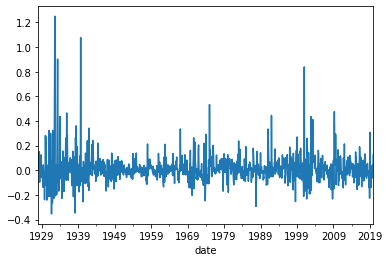

In [18]:
# calculate and visualize the characteristics of top and bottom portfolios
# mean of bottom portfolio
merged[merged['Q10_RET12']== 0].groupby('date')['RET'].mean().plot()

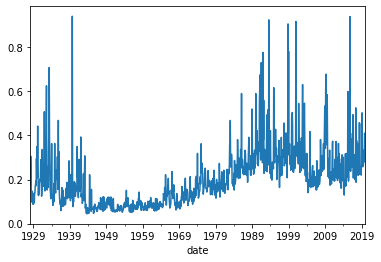

In [19]:
# standard deviation of bottom portfolio
merged[merged['Q10_RET12']== 0].groupby('date')['RET'].std().plot()

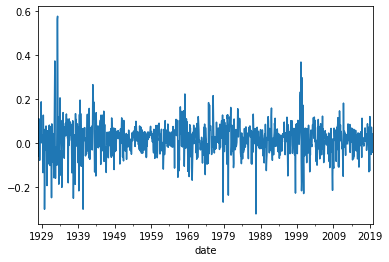

In [20]:
# mean of top portfolio
merged[merged['Q10_RET12']== 9].groupby('date')['RET'].mean().plot()

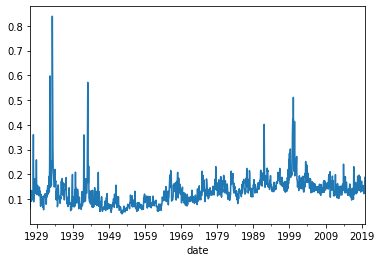

In [53]:
# standard deviation of top portfolio
merged[merged['Q10_RET12']== 9].groupby('date')['RET'].std().plot()

In [32]:
# Calculate characteristics of all portfolios in all months
merged_gbq=merged.groupby('Q10_RET12').describe()
port_ret=merged_gbq['RET']
port_ret

,count,mean,std,min,25%,50%,75%,max
Q10_RET12,,,,,,,,
0.0,282920.0,0.012976,0.298614,-0.993600,-0.120000,-0.011012,0.090909,19.000000
1.0,290161.0,0.010488,0.198716,-0.981295,-0.081081,0.000000,0.076271,13.495050
2.0,290824.0,0.010928,0.168665,-0.926702,-0.063670,0.000000,0.067708,24.000000
3.0,291147.0,0.011696,0.141029,-0.952703,-0.052778,0.000000,0.063636,5.562500
4.0,291161.0,0.012542,0.129640,-0.924577,-0.047210,0.003497,0.061350,7.480000
5.0,290528.0,0.013383,0.123327,-0.916667,-0.044118,0.005852,0.061303,4.018182
6.0,290194.0,0.014091,0.125601,-0.959091,-0.043716,0.006897,0.062780,10.344000
7.0,289418.0,0.015084,0.127644,-0.950000,-0.045373,0.007334,0.065897,6.166667
8.0,288079.0,0.015783,0.138615,-0.937500,-0.051431,0.007112,0.072165,6.908072


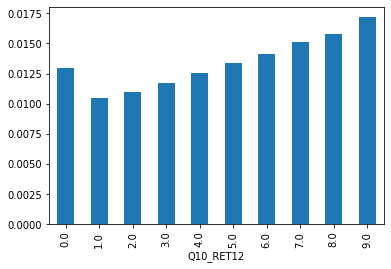

In [23]:
# this chart shows the mean return of 10 portfolios in all months
port_ret['mean'].plot(kind = 'bar')

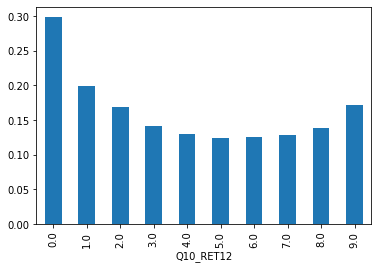

In [24]:
# this chart shows the standard deviation of 10 portfolios in all monthes
port_ret['std'].plot(kind = 'bar')

In [25]:
# Describe Strategy - prepare 
port = pd.DataFrame()
portfolios1 = merged.groupby(['date', 'Q10_RET12'])[['RET']].mean().unstack()
portfolios1.columns = ['RET_' + str(i) for i in range(10)]
port['strategy_ret']= (portfolios1['RET_9'] -  portfolios1['RET_0'])*100
port.reset_index(inplace = True)
port['strategy_excess'] = port['strategy_ret'] - ff['RF']
portfolios2 = pd.merge(ff, port[['date','strategy_ret','strategy_excess']],on = 'date')
portfolios2['log_mktrf'] = np.log(portfolios2['Mkt_RF']/100 + 1)
portfolios2['log_strategyrf'] = np.log(portfolios2['strategy_excess']/100 + 1)
portfolios2['log_mkt'] = np.log(portfolios2['Mkt']/100 + 1)
portfolios2['log_strategy'] = np.log(portfolios2['strategy_ret']/100 + 1)
portfolios2.set_index('date', inplace =True)

In [26]:
port

,date,strategy_ret,strategy_excess
0,1928-02-29,-7.213916,-7.433916
1,1928-03-31,5.433933,5.183933
2,1928-04-30,-6.128900,-6.358900
3,1928-05-31,-10.353505,-10.673505
4,1928-06-30,1.910393,1.600393
...,...,...,...
1098,2019-08-31,4.227480,4.117480
1099,2019-09-30,-8.108368,-8.218368
1100,2019-10-31,6.493778,6.373778
1101,2019-11-30,2.770538,2.630538


In [27]:
portfolios1

,RET_0,RET_1,RET_2,RET_3,RET_4,RET_5,RET_6,RET_7,RET_8,RET_9
date,,,,,,,,,,
1928-02-29,0.013518,-0.032255,-0.046103,0.005085,-0.017139,-0.026459,-0.031474,-0.025070,-0.042442,-0.058621
1928-03-31,0.057636,0.072778,0.059553,0.059536,0.052894,0.073901,0.055984,0.070600,0.122978,0.111975
1928-04-30,0.142321,0.184590,0.107077,0.147590,0.066971,0.075162,0.027398,0.051557,0.032474,0.081032
1928-05-31,0.151237,-0.014944,0.049685,0.006897,0.010619,0.017688,0.046769,0.018424,0.070917,0.047702
1928-06-30,-0.096420,-0.084013,-0.053595,-0.080872,-0.052946,-0.067429,-0.059976,-0.062516,-0.061097,-0.077316
...,...,...,...,...,...,...,...,...,...,...
2019-08-31,-0.064556,-0.079765,-0.085219,-0.069547,-0.050976,-0.045273,-0.047509,-0.035419,-0.028836,-0.022282
2019-09-30,0.039333,0.044416,0.042847,0.054427,0.040213,0.043623,0.033062,0.023063,0.008876,-0.041750
2019-10-31,-0.048069,-0.011331,-0.008531,0.008869,0.011211,0.027207,0.009156,0.015086,0.010126,0.016869


In [28]:
portfolios2

,Mkt_RF,SMB,HML,RF,Mkt,strategy_ret,strategy_excess,log_mktrf,log_strategyrf,log_mkt,log_strategy
date,,,,,,,,,,,
1928-02-29,-1.70,-2.03,-0.69,0.33,-1.37,-7.213916,-7.433916,-0.017146,-0.077247,-0.013795,-0.074874
1928-03-31,8.81,-0.26,-1.20,0.29,9.10,5.433933,5.183933,0.084433,0.050540,0.087095,0.052914
1928-04-30,4.23,3.82,3.67,0.22,4.45,-6.128900,-6.358900,0.041430,-0.065701,0.043538,-0.063248
1928-05-31,1.52,2.98,-3.46,0.32,1.84,-10.353505,-10.673505,0.015086,-0.112872,0.018233,-0.109296
1928-06-30,-4.85,-3.50,-0.06,0.31,-4.54,1.910393,1.600393,-0.049716,0.015877,-0.046463,0.018924
...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,-2.58,-2.41,-4.99,0.16,-2.42,4.227480,4.117480,-0.026139,0.040350,-0.024498,0.041406
2019-09-30,1.44,-0.90,6.71,0.18,1.62,-8.108368,-8.218368,0.014297,-0.085758,0.016070,-0.084560
2019-10-31,2.06,0.25,-2.07,0.15,2.21,6.493778,6.373778,0.020391,0.061789,0.021859,0.062916


In [61]:
portfolios2['strategy_ret'].std()

8.513350101068115

Text(0, 0.5, 'Return')

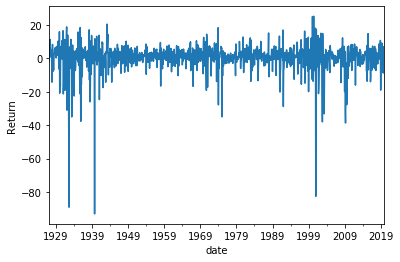

In [62]:
portfolios2['strategy_ret'].plot()
plt.ylabel('Return')

In [63]:
portfolios2['Mkt'].std()

5.32569720572521

Text(0, 0.5, 'Return')

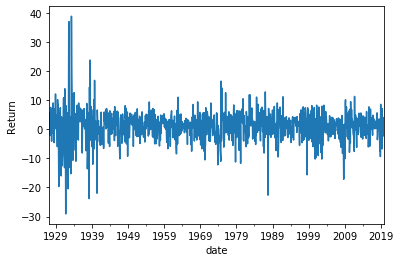

In [64]:
(portfolios2['Mkt']).plot()
plt.ylabel('Return')

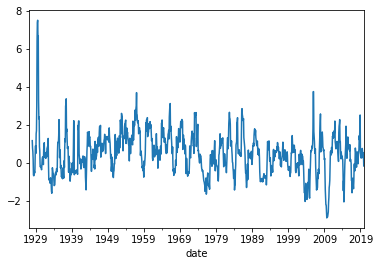

In [65]:
def SR(x):
    return np.sqrt(12) * np.mean(x) / np.std(x)
portfolios2['strategy_excess'].rolling(window = 12).apply(SR, raw = True).plot()


In [66]:
portfolios2['strategy_excess'].rolling(window = 12).apply(SR, raw = True).mean()

0.5075821533112309

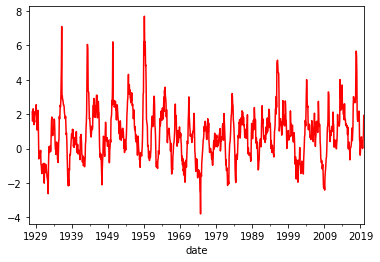

In [67]:
(portfolios2['Mkt_RF']).rolling(window = 12).apply(SR, raw = True).plot(color = 'red')

In [68]:
portfolios2['Mkt_RF'].rolling(window = 12).apply(SR, raw = True).mean()

0.8339766077330356

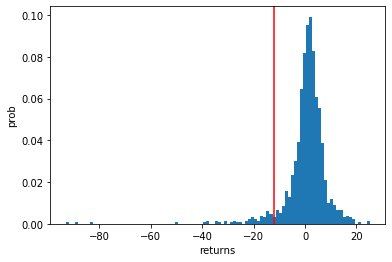

In [78]:
var_95percent_st = np.percentile(port['strategy_ret'], 5)
var_95percent_st_sorted = sorted(port['strategy_ret'])
plt.hist(var_95percent_st_sorted, density = True, bins = 100)
plt.axvline(x=var_95percent_st, color='r', linestyle='-',label="var_95percent_st".format(var_95percent_st))
plt.xlabel('returns')
plt.ylabel('prob')
plt.show()

In [81]:
var_95percent_st

-12.180351125887258

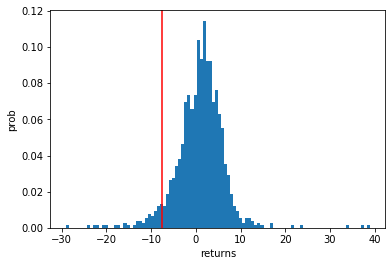

In [79]:
var_95percent_m = np.percentile(portfolios2['Mkt'], 5)
var_95percent_m_sorted = sorted(portfolios2['Mkt'])
plt.hist(var_95percent_m_sorted, density = True, bins = 100)
plt.axvline(x=var_95percent_m, color='r', linestyle='-',label="var_95percent_m".format(var_95percent_m))
plt.xlabel('returns')
plt.ylabel('prob')
plt.show()

In [82]:
var_95percent_m

-7.5